# PART 3

In [19]:
import cv2
import PIL
import pathlib
import tensorflow as tf
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import random
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
# Loading the Dataset
seed=123
batch_size=32
image_size=(64, 64)
validation_no=0.3
data = "/kaggle/input/cnn-dataset/cnn_dataset(1)"
data = pathlib.Path(data)

# Get the class names from the directory
class_names = sorted([i.name for i in data.glob('*') if i.is_dir()])

d_train = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split=validation_no,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size)

d_test = tf.keras.utils.image_dataset_from_directory(
    data,
    validation_split=validation_no,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size)


Found 30000 files belonging to 3 classes.
Using 21000 files for training.
Found 30000 files belonging to 3 classes.
Using 9000 files for validation.


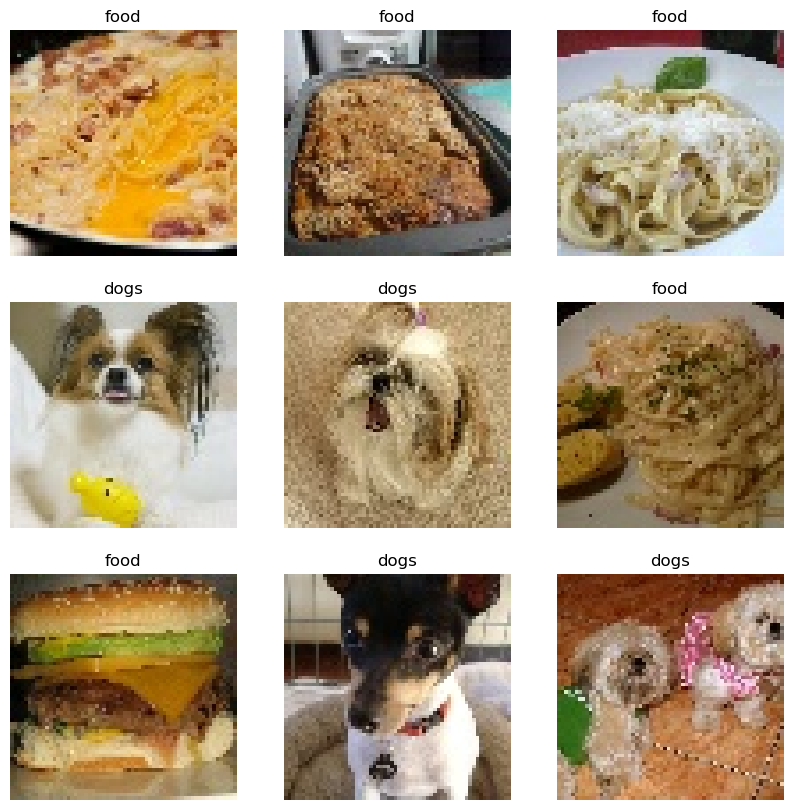

In [3]:
# Plotting sample images of the dataset
plt.figure(figsize=(10, 10))
for images, labels in d_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

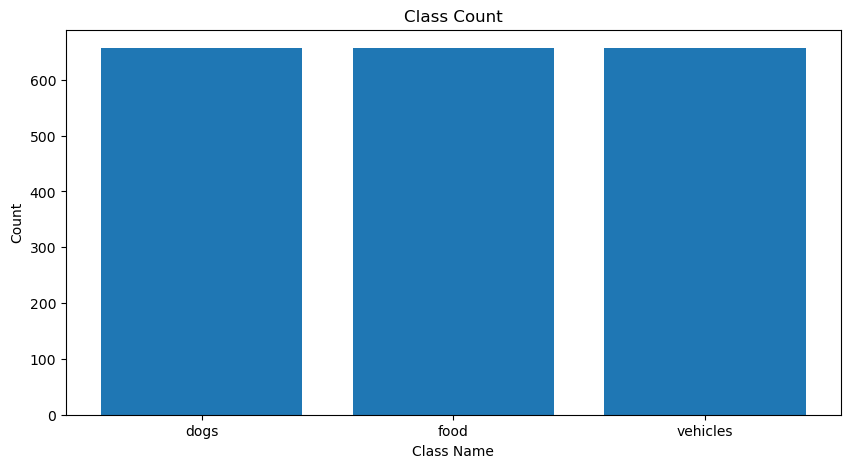

In [23]:
plt.figure(figsize=(10, 5))
class_count_train = (d_train.reduce(0, lambda x, _: x + 1).numpy())
plt.bar(class_names, class_count_train)
plt.title('Class Count')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.show()

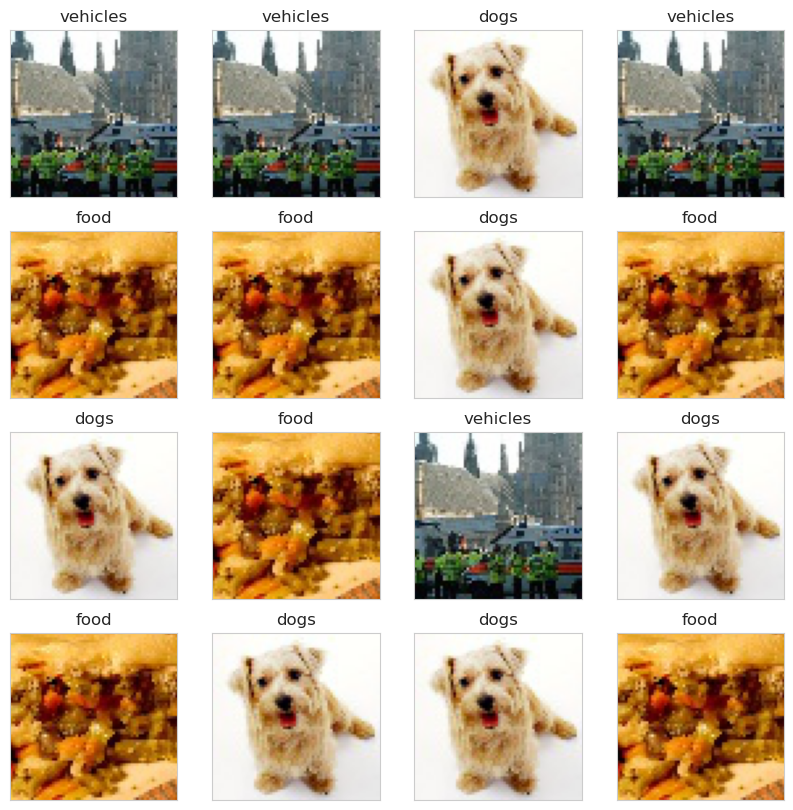

In [10]:
# Displaying random image from the dataset using random
class_names = d_train.class_names
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i in range(4):
    for j in range(4):
        class_index = random.randint(0, len(class_names)-1)
        class_folder = data/class_names[class_index]
        sample_images = list(class_folder.glob('*.jpg'))[:1]
        image_path = sample_images[0]
        image = plt.imread(str(image_path))
        axes[i,j].imshow(image)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])
        axes[i,j].set_title(f"{class_names[class_index]}")

### BUILDING A BASE ALEXNET MODEL

In [18]:
# Building the Alexnet model
i_shape = (64,64,3)
n_class = 3
inputs = tf.keras.layers.Input(shape=i_shape)

c1 = tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='same', activation='relu')(inputs)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(c1)
b1 = tf.keras.layers.BatchNormalization()(p1)
c2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(b1)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(c2)
b2 = tf.keras.layers.BatchNormalization()(p2)
c3 = tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(b2)
b3 = tf.keras.layers.BatchNormalization()(c3)
c4 = tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(b3)
bn4 = tf.keras.layers.BatchNormalization()(c4)
c5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(bn4)
p3 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(c5)
b5 = tf.keras.layers.BatchNormalization()(p3)
f = tf.keras.layers.Flatten()(b5)
dense1 = tf.keras.layers.Dense(units=4096, activation='relu')(f)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
dense2 = tf.keras.layers.Dense(units=4096, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
outputs = tf.keras.layers.Dense(units=n_class, activation='softmax')(dropout2)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    

In [24]:
# Training the base model and printing the accuracy with epoch
epochs = 10
learning_rate = 0.0001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tr_loss_list = []
tr_accuracy_list = []
te_loss_list = []
te_accuracy_list = []
best_accuracy = 0
best_epoch = 0
for epoch in range(epochs):
    tr_loss = tf.keras.metrics.Mean(name='train_loss')
    tr_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    te_loss = tf.keras.metrics.Mean(name='test_loss')
    te_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
    # Train loop
    for images, labels in d_train:
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        tr_loss(loss)
        tr_accuracy(labels, predictions)
    
    tr_loss_list.append(tr_loss.result())
    tr_accuracy_list.append(tr_accuracy.result())
    
    # Test loop
    for test_images, test_labels in d_test:
        predictions = model(test_images, training=False)
        t_loss = loss_object(test_labels, predictions)
        te_loss(t_loss)
        te_accuracy(test_labels, predictions)
    
    te_loss_list.append(te_loss.result())
    te_accuracy_list.append(te_accuracy.result())
    if te_accuracy.result() > best_accuracy:
        best_accuracy = te_accuracy.result()
        best_epoch = epoch + 1

    print(
        f'Epoch {epoch + 1}, '
        f'Accuracy: {te_accuracy.result() * 100}'
    )
print("\n\n")    
print(
        f'Best Epoch {best_epoch}, '
        f'Best Accuracy: {best_accuracy * 100}'
    )

Epoch 1, Accuracy: 81.02222442626953
Epoch 2, Accuracy: 89.0111083984375
Epoch 3, Accuracy: 89.62222290039062
Epoch 4, Accuracy: 89.14444732666016
Epoch 5, Accuracy: 78.0888900756836
Epoch 6, Accuracy: 78.75555419921875
Epoch 7, Accuracy: 87.85555267333984
Epoch 8, Accuracy: 89.4111099243164
Epoch 9, Accuracy: 85.65555572509766
Epoch 10, Accuracy: 87.22222137451172



Best Epoch 3, Best Accuracy: 89.62222290039062


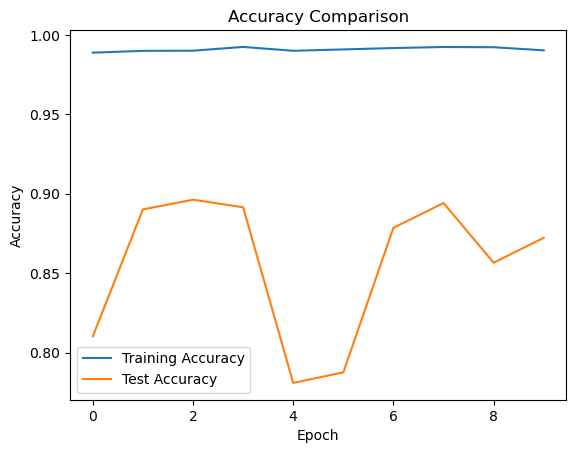

In [27]:
# Plotting Training accuracy and Test Accuracy
plt.plot(tr_accuracy_list, label='Training Accuracy')
plt.plot(te_accuracy_list, label='Test Accuracy')
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

###  APPLYING EARLY STOPPING

In [31]:
# training the base model with early stopping and printing the accuracy for each epoch
epochs = 20
learning_rate = 0.0001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tr_loss_list = []
tr_accuracy_list = []
te_loss_list = []
te_accuracy_list = []
best_accuracy = 0
best_epoch = 0
patience = 5  
improvement = 0

for epoch in range(epochs):
    tr_loss = tf.keras.metrics.Mean(name='train_loss')
    tr_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    te_loss = tf.keras.metrics.Mean(name='test_loss')
    te_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
    # Train loop
    for images, labels in d_train:
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        tr_loss(loss)
        tr_accuracy(labels, predictions)
    
    tr_loss_list.append(tr_loss.result())
    tr_accuracy_list.append(tr_accuracy.result())
    
    # Test loop
    for test_images, test_labels in d_test:
        predictions = model(test_images, training=False)
        t_loss = loss_object(test_labels, predictions)
        te_loss(t_loss)
        te_accuracy(test_labels, predictions)
    
    te_loss_list.append(te_loss.result())
    te_accuracy_list.append(te_accuracy.result())

    # Check if validation accuracy has stopped improving
    if te_accuracy.result() > best_accuracy:
        best_accuracy = te_accuracy.result()
        best_epoch = epoch + 1
        improvement = 0 
    else:
        improvement += 1
    print(
        f'Epoch {epoch + 1}, '
        f'Accuracy: {te_accuracy.result() * 100}'
    )
    if improvement >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break


print("\n\n")    
print(
        f'Best Epoch {best_epoch}, '
        f'Best Accuracy: {best_accuracy * 100}'
    )

Epoch 1, Accuracy: 87.9111099243164
Epoch 2, Accuracy: 88.522216796875
Epoch 3, Accuracy: 81.74444580078125
Epoch 4, Accuracy: 89.53333282470703
Epoch 5, Accuracy: 89.60000610351562
Epoch 6, Accuracy: 89.16666412353516
Epoch 7, Accuracy: 85.92222595214844
Epoch 8, Accuracy: 88.87777709960938
Epoch 9, Accuracy: 90.20000457763672
Epoch 10, Accuracy: 83.71111297607422
Epoch 11, Accuracy: 89.93333435058594
Epoch 12, Accuracy: 89.4888916015625
Epoch 13, Accuracy: 90.04444122314453
Epoch 14, Accuracy: 89.35556030273438
Early stopping at epoch 14



Best Epoch 9, Best Accuracy: 90.20000457763672


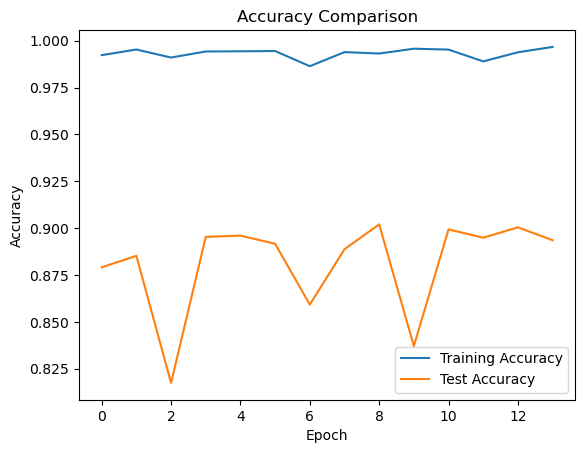

In [32]:
# Plotting Training accuracy and Test Accuracy
plt.plot(tr_accuracy_list, label='Training Accuracy')
plt.plot(te_accuracy_list, label='Test Accuracy')
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# PART 4

In [52]:
import scipy.io
batch_size = 32
image_size = (64, 64)
validation_no = 0.3

# Path to the train and test data files
train_data_file = "/kaggle/input/svhn-part4/train_32x32.mat"
test_data_file = "/kaggle/input/svhn-part4/test_32x32.mat"

# Load the train data
train_data = scipy.io.loadmat(train_data_file)
train_images = np.transpose(train_data['X'], (3, 0, 1, 2))
train_labels = train_data['y'].squeeze()
train_labels[train_labels == 10] = 0  
class_names = [str(i) for i in range(10)]
num_classes = len(class_names)
d_train = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
d_train = d_train.shuffle(buffer_size=10000, seed=123)
d_train = d_train.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
d_train = d_train.batch(batch_size)

# Load the test data
test_data = scipy.io.loadmat(test_data_file)
test_images = np.transpose(test_data['X'], (3, 0, 1, 2))
test_labels = test_data['y'].squeeze()
test_labels[test_labels == 10] = 0  
d_test = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
d_test = d_test.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
d_test = d_test.batch(batch_size=batch_size)

Number of samples in train dataset: 73280
Number of samples in test dataset: 26048


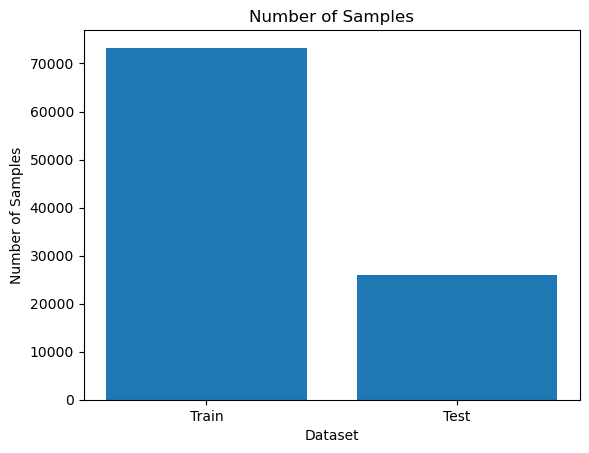

In [29]:
# Print number of samples in train and test datasets
print("Number of samples in train dataset:", len(d_train) * 32)
print("Number of samples in test dataset:", len(d_test) * 32)
plt.bar(["Train", "Test"], [len(d_train)*32, len(d_test)*32])
plt.title("Number of Samples")
plt.xlabel("Dataset")
plt.ylabel("Number of Samples")
plt.show()

In [46]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2
    image = tf.image.resize(image, (64, 64))
    return image, label
d_train_augmented = d_train.map(augment)
d_train = d_train_augmented.concatenate(d_train.map(augment))

In [47]:
# Building the Alexnet model
i_shape = (64,64,3)
n_class = 10
inputs = tf.keras.layers.Input(shape=i_shape)

c1 = tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='same', activation='relu')(inputs)
p1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(c1)
b1 = tf.keras.layers.BatchNormalization()(p1)
c2 = tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(b1)
p2 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(c2)
b2 = tf.keras.layers.BatchNormalization()(p2)
c3 = tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(b2)
b3 = tf.keras.layers.BatchNormalization()(c3)
c4 = tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(b3)
bn4 = tf.keras.layers.BatchNormalization()(c4)
c5 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(bn4)
p5 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(c5)
b5 = tf.keras.layers.BatchNormalization()(p5)
f = tf.keras.layers.Flatten()(b5)
dense1 = tf.keras.layers.Dense(units=4096, activation='relu')(f)
dropout1 = tf.keras.layers.Dropout(0.5)(dense1)
dense2 = tf.keras.layers.Dense(units=4096, activation='relu')(dropout1)
dropout2 = tf.keras.layers.Dropout(0.5)(dense2)
outputs = tf.keras.layers.Dense(units=n_class, activation='softmax')(dropout2)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    

In [50]:
# training the base model with early stopping and printing the accuracy for each epoch
epochs = 10
learning_rate = 0.0001
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

tr_loss_list = []
tr_accuracy_list = []
te_loss_list = []
te_accuracy_list = []
best_accuracy = 0
best_epoch = 0
patience = 5  
improvement = 0

for epoch in range(epochs):
    tr_loss = tf.keras.metrics.Mean(name='train_loss')
    tr_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
    te_loss = tf.keras.metrics.Mean(name='test_loss')
    te_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
    
    # Train loop
    for images, labels in d_train:
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        tr_loss(loss)
        tr_accuracy(labels, predictions)
    
    tr_loss_list.append(tr_loss.result())
    tr_accuracy_list.append(tr_accuracy.result())
    
    # Test loop
    for test_images, test_labels in d_test:
        test_images = tf.image.resize(test_images, (64, 64))
        predictions = model(test_images, training=False)
        t_loss = loss_object(test_labels, predictions)
        te_loss(t_loss)
        te_accuracy(test_labels, predictions)
    
    te_loss_list.append(te_loss.result())
    te_accuracy_list.append(te_accuracy.result())

    # Check if validation accuracy has stopped improving
    if te_accuracy.result() > best_accuracy:
        best_accuracy = te_accuracy.result()
        best_epoch = epoch + 1
        improvement = 0 
    else:
        improvement += 1
    print(
        f'Epoch {epoch + 1}, '
        f'Accuracy: {te_accuracy.result() * 100}'
    )
    if improvement >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

print("\n\n")    
print(
        f'Best Epoch {best_epoch}, '
        f'Best Accuracy: {best_accuracy * 100}'
    )

Epoch 1, Accuracy: 87.2887191772461
Epoch 2, Accuracy: 89.37845611572266
Epoch 3, Accuracy: 89.01351928710938
Epoch 4, Accuracy: 89.539794921875
Epoch 5, Accuracy: 89.14412689208984
Epoch 6, Accuracy: 87.43470001220703
Epoch 7, Accuracy: 89.57820892333984
Epoch 8, Accuracy: 88.48724365234375
Epoch 9, Accuracy: 88.71005249023438
Epoch 10, Accuracy: 90.03150177001953



Best Epoch 10, Best Accuracy: 90.03150177001953


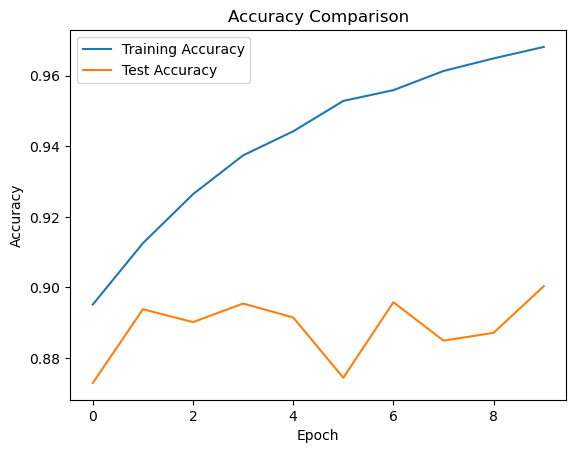

In [51]:
# Plotting Training accuracy and Test Accuracy
plt.plot(tr_accuracy_list, label='Training Accuracy')
plt.plot(te_accuracy_list, label='Test Accuracy')
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()